In [1]:
# In simple terms, problem of calibration is to find parameters for the proposed model such that observed market quotes of liquidly traded plain vanilla options are replicated as closely as possible. The general approach is that, one defines an error function that is to be minimized.

In this below, we will use 
- Sep-30-2014 Market quote on call options underlying Euro Stoxx 50 
- BSM model
- RMSE as an error function

to illustrate the calibration of volatility.




In [2]:
import numpy as np
import pandas as pd
import scipy.optimize as sop

In [3]:
# Market Data from www.eurexchange.com
# as of 30. September 2014
# European call & put option data (3 maturities)

options = pd.read_csv('SX5E_Options_140930.csv')
S0 = 3225.93  # EURO STOXX 50 level
r = 0.0005  # ECB base rate
options['Date'] = pd.to_datetime(options['Date'])
options['Maturity'] = pd.to_datetime(options['Maturity'])

options

,Date,Strike,Call,Maturity,Put
0,2014-09-30,3175.0,126.8,2014-12-19,78.8
1,2014-09-30,3200.0,110.9,2014-12-19,87.9
2,2014-09-30,3225.0,96.1,2014-12-19,98.1
3,2014-09-30,3250.0,82.3,2014-12-19,109.3
4,2014-09-30,3275.0,69.6,2014-12-19,121.6
5,2014-09-30,3175.0,171.0,2015-03-20,129.2
6,2014-09-30,3200.0,156.1,2015-03-20,139.4
7,2014-09-30,3225.0,142.0,2015-03-20,150.3
8,2014-09-30,3250.0,128.5,2015-03-20,161.8
9,2014-09-30,3275.0,115.8,2015-03-20,174.0


The above data is the market quote on Sep-30-2014 on call and put options underlying Euro Stoxx 50. The question of the calibration is, given that the market follows BSM, what is the volatility $\sigma$ fitting to the above market quote?



In [4]:
from BSM_option_valuation import *

def generate_plot(opt, options):
    #
    # Calculating Model Prices
    #
    sigma = opt
    options['Model'] = 0.0
    for row, option in options.iterrows():
        T = (option['Maturity'] - option['Date']).days / 365.
        options.loc[row, 'Model'] = BSM_call_value(S0, option['Strike'], 0, T, r, sigma)

    #
    # Plotting
    #
    mats = sorted(set(options['Maturity']))
    options = options.set_index('Strike')
    for i, mat in enumerate(mats):
        options[options['Maturity'] == mat][['Call', 'Model']].\
            plot(style=['b-', 'ro'], title='%s' % str(mat)[:10],
                 grid=True)
        plt.ylabel('option value')
        plt.savefig('BSM_calibration_3_%s.pdf' % i)

The following graph shows that how the market data differs from the theoretical price by just making a guess of $30\%$ volatility.

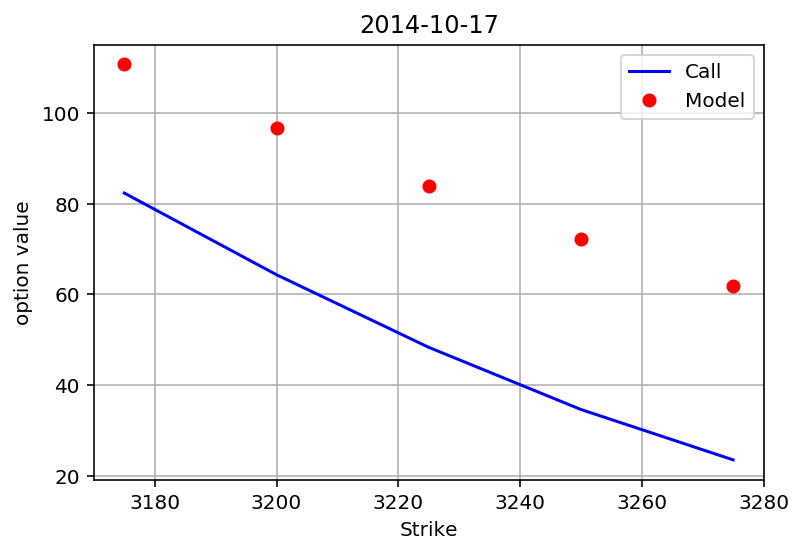

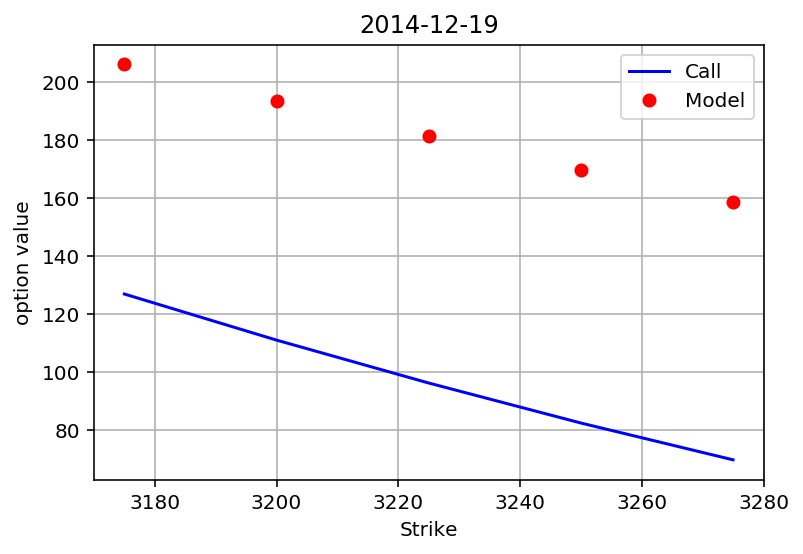

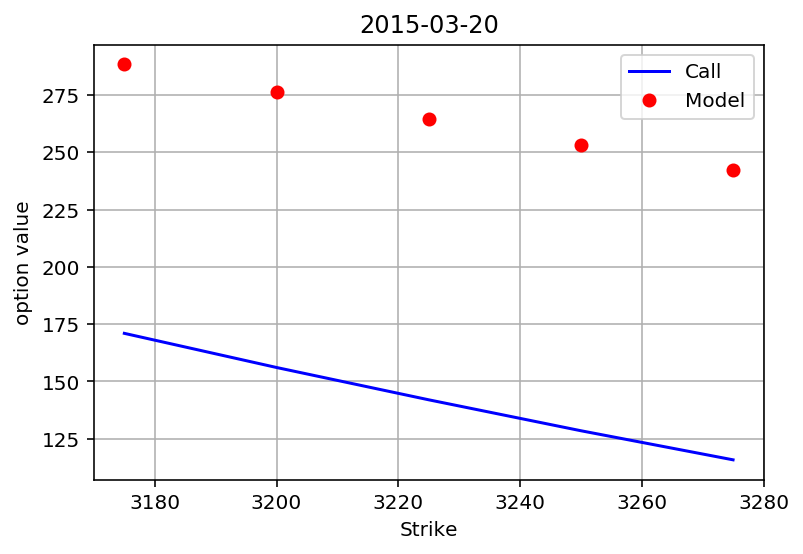

In [5]:
generate_plot(.3, options); #Arbitrary input for the volatility

## Calibration by minimizing RMSE

Suppose there are $N$ options available in the market quote with various strike and maturities. We denote the market quotes of $N$ options by 
$$\{C_n^*: \quad n = 1, 2, \ldots, N.\}.$$ Correpondinly, there are $N$ BSM theoretical prices available as a function of the volatility. We denote it by
$$\{C_n(\sigma): \quad n = 1, 2, \ldots, N.\}$$
The error function RMSE is defined by
$$RMSE(\sigma) = \sqrt{\frac 1 N \sum_{n = 1}^N \Big| C_n^* - C_n(\sigma) \Big|^2}.$$
Our goal is to find out the calibrated volatility $\hat \sigma$, which is given by
$$\hat \sigma = \arg \min_\sigma RMSE(\sigma).$$

In [6]:
# Error Function
#
def BSM_error_function(p0):
    ''' Error Function for parameter calibration in BSM Model via
    
    Parameters
    ==========
    sigma: float
        volatility factor in diffusion term

    Returns
    =======
    RMSE: float
        root mean squared error
    '''
    global i, min_RMSE
    sigma = p0
    if sigma < 0.0:
        return 500.0
    se = []
    for row, option in options.iterrows():
        T = (option['Maturity'] - option['Date']).days / 365.
        model_value = BSM_call_value(S0, option['Strike'], 0, T, r, sigma)
        se.append((model_value - option['Call']) ** 2)
    RMSE = math.sqrt(sum(se) / len(se))
    min_RMSE = min(min_RMSE, RMSE)
    if i % 5 == 0:
        print('%4d |' % i, np.array(p0), '| %7.3f | %7.3f' % (RMSE, min_RMSE))
    i += 1
    return RMSE



In [7]:
# Calibration initialization
#
i = 0  # counter initialization
min_RMSE = 200  # minimal RMSE initialization
opt = sop.fmin(BSM_error_function, 0.5,
               maxiter=500, maxfun=750,
               xtol=0.000001, ftol=0.000001)

   0 | [0.5] | 214.284 | 200.000
   5 | [0.35] | 119.761 | 119.761
  10 | [0.2] |  25.162 |   7.525
  15 | [0.175] |   9.808 |   3.796


  20 | [0.1609375] |   3.594 |   3.594
  25 | [0.1609375] |   3.594 |   3.584
  30 | [0.16049805] |   3.584 |   3.584
  35 | [0.16049805] |   3.584 |   3.584
  40 | [0.16051178] |   3.584 |   3.584


Optimization terminated successfully.
         Current function value: 3.584264
         Iterations: 22
         Function evaluations: 44


In [8]:
print(opt)

[0.16051331]


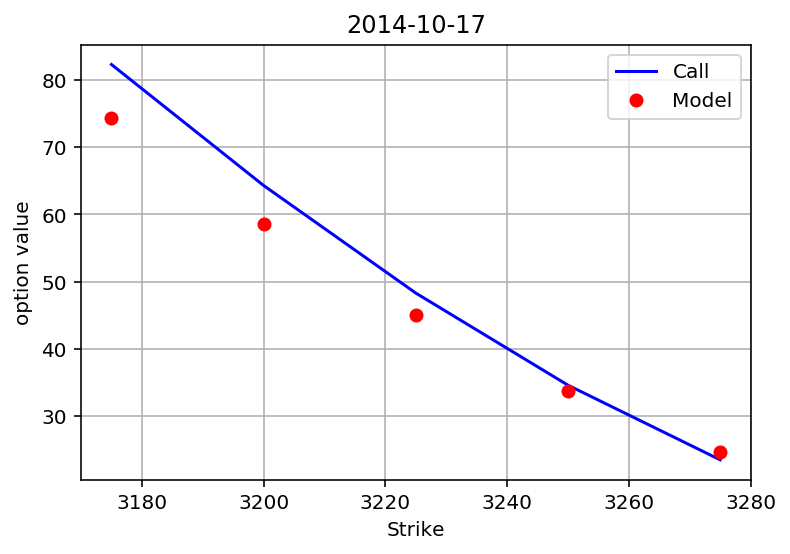

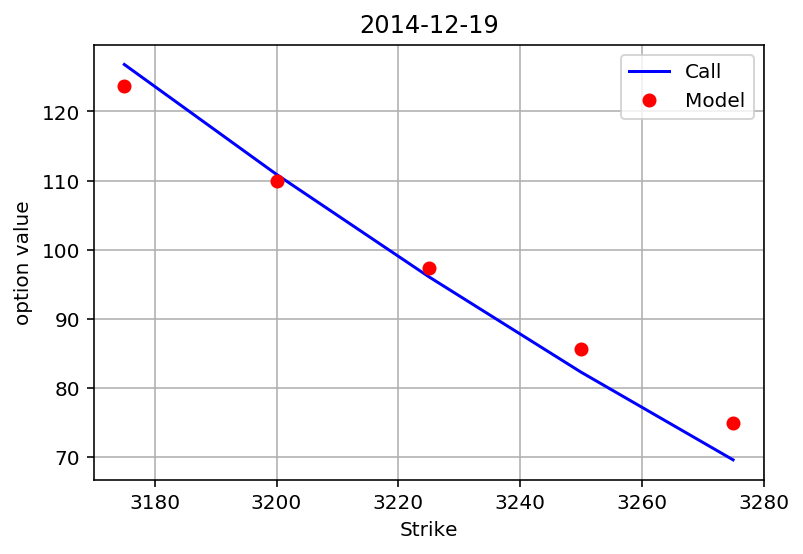

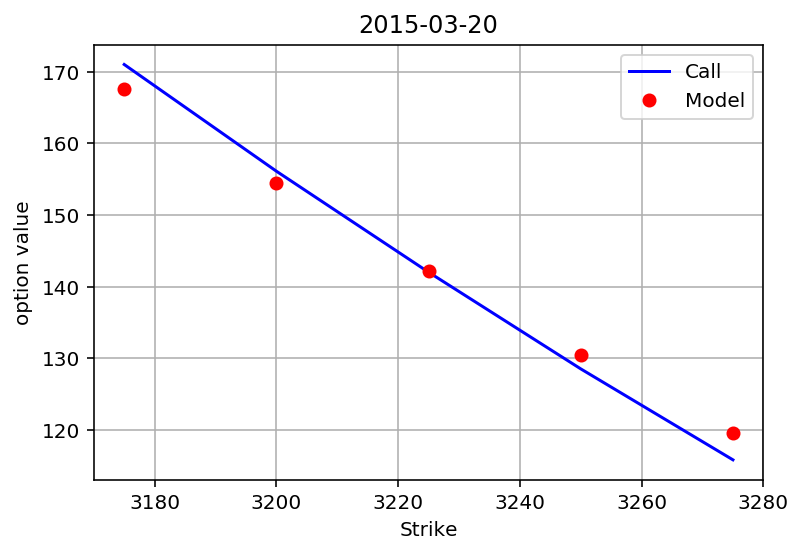

In [9]:
generate_plot(opt, options);

In [0]:
# rewrite the code

In [1]:
# to illustrate the calibration of volatility.
import numpy as np
import pandas as pd
import scipy.optimize as sop

In [3]:
#input data.

# Market Data from www.eurexchange.com
# as of 30. September 2014
# European call & put option data (3 maturities)

options = pd.read_csv('SX5E_Options_140930.csv')
S0 = 3225.93  # EURO STOXX 50 level
r = 0.0005  # ECB base rate
options['Date'] = pd.to_datetime(options['Date'])
options['Maturity'] = pd.to_datetime(options['Maturity'])

options

,Date,Strike,Call,Maturity,Put
0,2014-09-30,3175.0,126.8,2014-12-19,78.8
1,2014-09-30,3200.0,110.9,2014-12-19,87.9
2,2014-09-30,3225.0,96.1,2014-12-19,98.1
3,2014-09-30,3250.0,82.3,2014-12-19,109.3
4,2014-09-30,3275.0,69.6,2014-12-19,121.6
5,2014-09-30,3175.0,171.0,2015-03-20,129.2
6,2014-09-30,3200.0,156.1,2015-03-20,139.4
7,2014-09-30,3225.0,142.0,2015-03-20,150.3
8,2014-09-30,3250.0,128.5,2015-03-20,161.8
9,2014-09-30,3275.0,115.8,2015-03-20,174.0


In [4]:
# The above data is the market quote on Sep-30-2014 on call and put options underlying Euro Stoxx 50. The question of the calibration is, given that the market follows BSM, what is the volatility $\sigma$ fitting to the above market quote?

In [5]:
from BSM_option_valuation import *
# (St,K,t,T,r,sigma)

In [14]:
def generate_plot(opt, options):
    #
    # Calculating Model Prices
    #
    sigma = opt
    options['Model'] = 0.0
    for row, option in options.iterrows():
        # T-t
        T = (option['Maturity'] - option['Date']).days / 365.
        options.loc[row, 'Model'] = BSM_call_value(S0, option['Strike'], 0, T, r, sigma)

    #
    # Plotting
    #
     # 按到期日排序
    mats = sorted(set(options['Maturity']))
    options = options.set_index('Strike')
    for i, mat in enumerate(mats):
        options[options['Maturity'] == mat][['Call', 'Model']].\
            plot(style=['b-', 'ro'], title='%s' % str(mat)[:10],grid=True)
            
        plt.ylabel('option value')
        plt.savefig('BSM_calibration_3_%s.pdf' % i)

In [15]:
# The following graph shows that how the market data differs from the theoretical price by just making a guess of $30\%$ volatility.

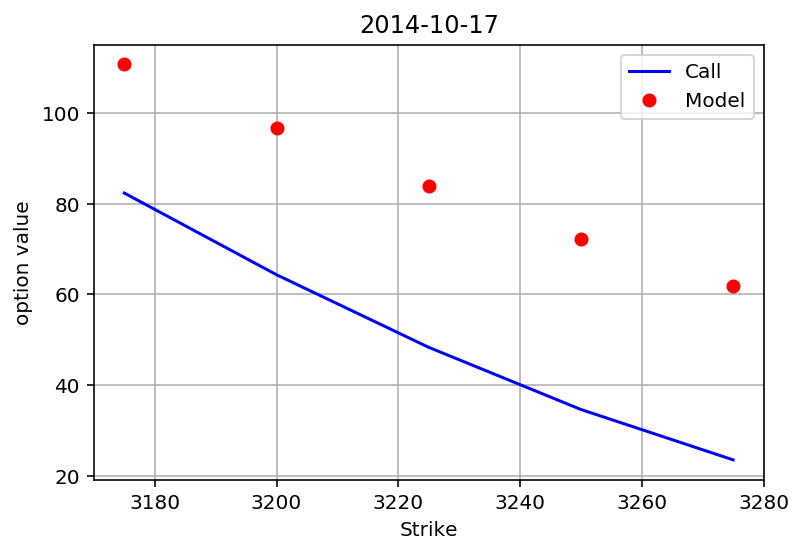

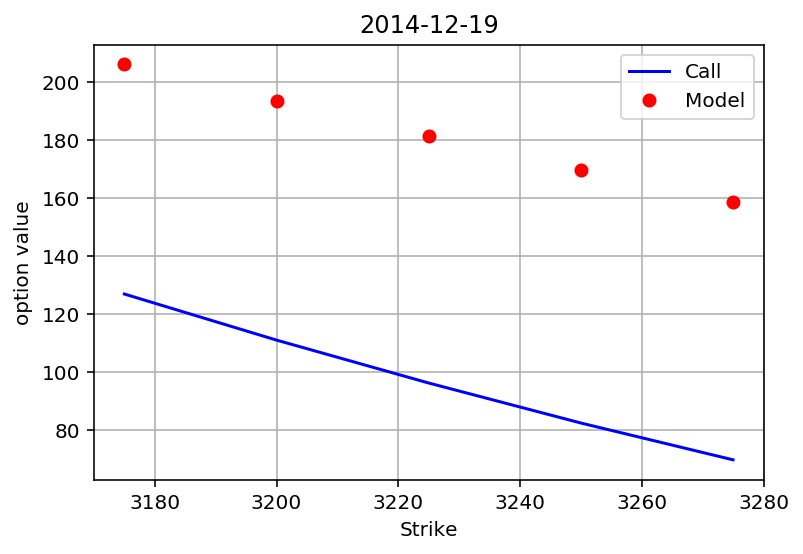

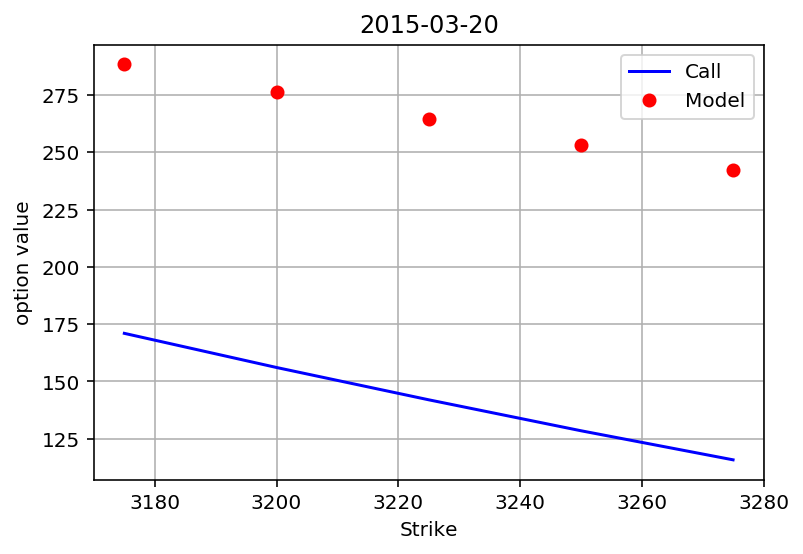

In [16]:
generate_plot(.3, options); #Arbitrary input for the volatility

In [9]:
# Error Function

In [10]:

#
def BSM_error_function(p0):
    ''' Error Function for parameter calibration in BSM Model via
    
    Parameters
    ==========
    sigma: float
        volatility factor in diffusion term

    Returns
    =======
    RMSE: float
        root mean squared error
    '''
    global i, min_RMSE
    sigma = p0
    if sigma < 0.0:
        return 500.0
    se = []
    for row, option in options.iterrows():
        T = (option['Maturity'] - option['Date']).days / 365.
        model_value = BSM_call_value(S0, option['Strike'], 0, T, r, sigma)
        # append（）在尾部增加一列元素
        se.append((model_value - option['Call']) ** 2)
    # len()计算列表元素个数
    RMSE = math.sqrt(sum(se) / len(se))
    min_RMSE = min(min_RMSE, RMSE)
    # a%b 求a/b的余数
    if i % 5 == 0:
        print('%4d |' % i, np.array(p0), '| %7.3f | %7.3f' % (RMSE, min_RMSE))
    i += 1
    return RMSE

In [11]:
# Calibration initialization
#
i = 0  # counter initialization
min_RMSE = 200  # minimal RMSE initialization
opt = sop.fmin(BSM_error_function, 0.5,
               maxiter=500, maxfun=750,
               xtol=0.000001, ftol=0.000001)

   0 | [0.5] | 214.284 | 200.000
   5 | [0.35] | 119.761 | 119.761
  10 | [0.2] |  25.162 |   7.525
  15 | [0.175] |   9.808 |   3.796
  20 | [0.1609375] |   3.594 |   3.594


  25 | [0.1609375] |   3.594 |   3.584
  30 | [0.16049805] |   3.584 |   3.584
  35 | [0.16049805] |   3.584 |   3.584
  40 | [0.16051178] |   3.584 |   3.584
Optimization terminated successfully.
         Current function value: 3.584264
         Iterations: 22
         Function evaluations: 44


In [12]:
print(opt)

[0.16051331]


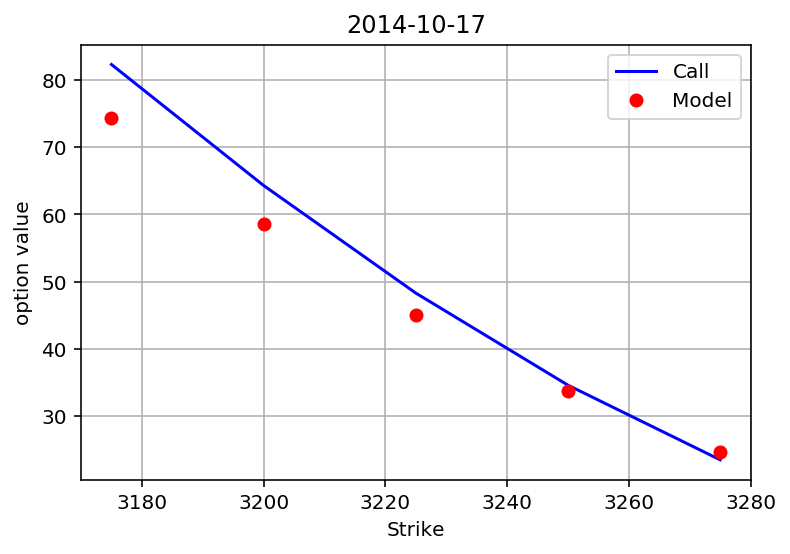

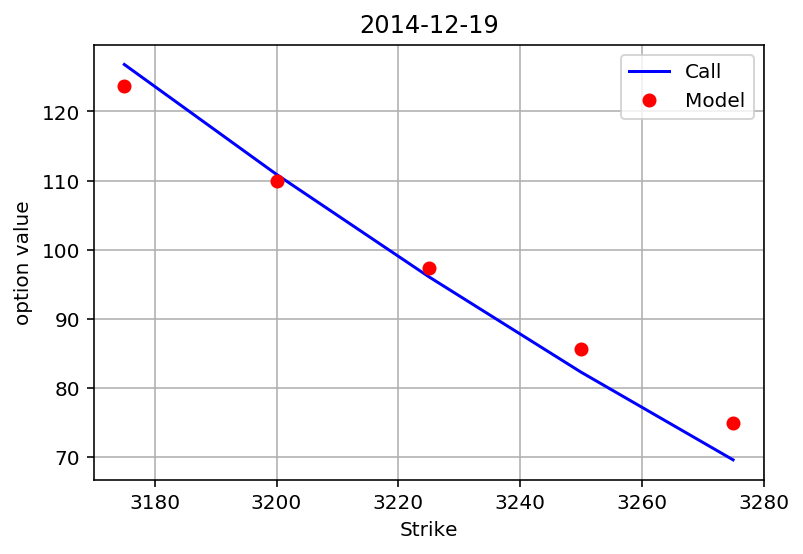

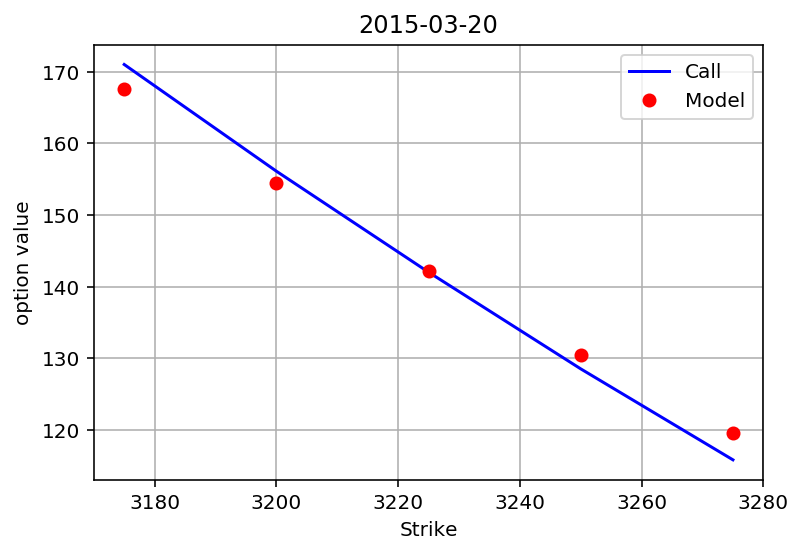

In [13]:
generate_plot(opt, options);